In [1]:
import tensorflow as tf
import numpy as np
import itertools
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [3]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import initializers, optimizers
from keras.layers import Input, BatchNormalization
from keras.layers import  Dense, Flatten, Activation, Dropout, Embedding
from keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, merge, Input,Multiply
from keras.utils import np_utils
from keras.layers.wrappers import  Bidirectional
from keras.layers import *
from keras import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2 
from keras.models import load_model
import keras

Using TensorFlow backend.


In [4]:
from os import listdir
from os.path import isfile, join
import glob
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
mypath = '/home/chenming/ncrna/ncRDeep2/Data_Processing/RNAfold/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
my_files8 = glob.glob("/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot*.h5")
my_files8.sort()
my_files8[0:2]

['/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Test_Data_750.h5',
 '/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Train_Data_750.h5']

In [7]:
my_files7 = glob.glob("/home/chenming/ncrna/ncRDeep2/Data_Processing/RNAfold/*.h5")
my_files7.sort()
my_files7[0:2]

['/home/chenming/ncrna/ncRDeep2/Data_Processing/RNAfold/SS_test_0.h5',
 '/home/chenming/ncrna/ncRDeep2/Data_Processing/RNAfold/SS_test_1.h5']

In [8]:
def get_file8(fold_no): #get train and test data from file by fold number
    hf_Train = h5.File(my_files8[fold_no*2+1],'r')
    hf_Test = h5.File(my_files8[fold_no*2],'r')
    X_train = hf_Train['Train_Data'] # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Train['Label']      # Get train label
    Y_train = np.array(Y_train)
    X_test = hf_Test['Test_Data']     # Get test set
    X_test = np.array(X_test)
    Y_test = hf_Test['Label']       # Get test label
    Y_test = np.array(Y_test)
    Y_train = np_utils.to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = np_utils.to_categorical(Y_test, 13)    #  Process the label of test
    return X_train, Y_train, X_test, Y_test

In [9]:
def get_file7(fold_no): #get train and test data from file by fold number
    hf_Train = h5.File(my_files7[10+fold_no],'r')
    hf_Test = h5.File(my_files7[fold_no],'r')
    X_train = hf_Train['Train_Data'] # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Train['Label']      # Get train label
    Y_train = np.array(Y_train)
    X_test = hf_Test['Test_Data']     # Get test set
    X_test = np.array(X_test)
    Y_test = hf_Test['Label']       # Get test label
    Y_test = np.array(Y_test)
    Y_train = np_utils.to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = np_utils.to_categorical(Y_test, 13)    #  Process the label of test
    return X_train, Y_train, X_test, Y_test

In [10]:
class_names = ['5S_rRNA', '5.8S_rRNA', 'tRNA', 'ribozymes', 'CD-box', 'miRNA', 'Intron_gpI', 'Intron_gpII', 'HACA-box', 'riboswitch', 'IRES', 'leader', 'scaRNA']
class_names

['5S_rRNA',
 '5.8S_rRNA',
 'tRNA',
 'ribozymes',
 'CD-box',
 'miRNA',
 'Intron_gpI',
 'Intron_gpII',
 'HACA-box',
 'riboswitch',
 'IRES',
 'leader',
 'scaRNA']

In [11]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    FONT_SIZE = 10
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n============================")
    else:
        #cm = np.asfarray(cm,float64)
        print('Confusion matrix, without normalization\n============================')
    #print(cm)
    plt.figure(figsize=(5*2, 4*2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=FONT_SIZE)
    plt.yticks(tick_marks, classes, fontsize=FONT_SIZE)
    fmt = '.3f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=FONT_SIZE)
    plt.xlabel('Predicted label', fontsize=FONT_SIZE)
    plt.savefig('Conf_mat_avg.pdf')
    plt.show()

In [12]:
def Conv1Dme(f, k, x):
    x1=Conv1D(filters=f,kernel_size=k,strides=1,padding="same",kernel_initializer=initializers.random_uniform()) (x)
    x1 = BatchNormalization()(x1)
    x1=Dropout(0.2)(x1)
    x1=Activation('relu')(x1)
    #x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    return x1

In [13]:
def dense_block_1(xin, f, k, p):
    f1 = f
    k1 = k
    p1 = p

    x1 = Conv1Dme(f1, k1, xin)
    x11 = Conv1Dme(f1, k1, x1)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x1=MaxPooling1D(pool_size=p1, strides=p1)(x11)
    
    return x1

In [14]:
def fc_block_1(xin, n):
    xf=Dense(n,)(xin)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    return xf

In [15]:
def model_dense5(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 3))
    
    ###############################################################
    #          1st dense block
    
    x1 = Conv1Dme(64, 5, inputs1)
    x1 = MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 5, 4)
    x1 = dense_block_1(x1, 128, 5, 4)
    x1 = Conv1Dme(64, 5, x1)
    x1 = MaxPooling1D(pool_size=2, strides=2)(x1)
    
    
    ###############################################################
    #          2nd dense block
    
    x2 = Conv1Dme(64, 5, inputs2)
    x2 = MaxPooling1D(pool_size=2, strides=2)(x2)
    
    x2 = dense_block_1(x2, 128, 5, 4)
    x2 = dense_block_1(x2, 128, 5, 4)
    x2 = Conv1Dme(64, 5, x2)
    x2 = MaxPooling1D(pool_size=2, strides=2)(x2)
    
    xf=keras.layers.concatenate([x1,x2],axis=-1)
    
    #xf = dense_block_1(xf, 256, 5, 2)
    xf = Conv1Dme(64, 3, xf)
    xf = MaxPooling1D(pool_size=2, strides=2)(xf)
    xf = Flatten()(xf)

    xf=fc_block_1(xf, 256)
    xf=fc_block_1(xf, 64)
    
    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0005),metrics=['accuracy'])
    
    return model

In [16]:
hf_val = h5.File(my_files7[20],'r')
X_val = hf_val['Test_Data']     # Get test set
X_val = np.array(X_val)
Y_val = hf_val['Label']       # Get test label
Y_val = np.array(Y_val)
Y_val = np_utils.to_categorical(Y_val, 13)    #  Process the label of test

In [21]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file7(i)
    model = model_dense5()
    #es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    #history = model.fit([X_train[:,:,0:4],X_train[:,:,4:7]], Y_train, validation_data=([X_test[:,:,0:4],X_test[:,:,4:7]], Y_test), epochs=200, verbose=0, callbacks=[es])
    model.load_weights("Checkpoints/Dense_RNAfold_revise2_%i_fold.h5" %i)
    y = model.predict([X_test[:,:,0:4],X_test[:,:,4:7]])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    #history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.9493670886075949, 0.948173076923077, 0.948449103471994, 0.947549611817262, 0.9452469486796395)
(0.9604430379746836, 0.9572115384615384, 0.9583564464204151, 0.9572997789960724, 0.957205377517478)
(0.9462025316455697, 0.9425, 0.9486447716020396, 0.9443103802418304, 0.9418318169152613)
(0.9477848101265823, 0.9449038461538463, 0.9480705298339038, 0.9453873988666892, 0.9436258639657762)
(0.930379746835443, 0.9279807692307691, 0.9299145020834483, 0.9280918101799694, 0.9246836669516679)
(0.930379746835443, 0.9297115384615384, 0.9322958392589924, 0.9303772063404252, 0.9246560511520936)
(0.9256329113924051, 0.9190384615384615, 0.9269719590417943, 0.9209377851411393, 0.9196614255226412)
(0.9382911392405063, 0.9313461538461538, 0.9409309036464164, 0.9338366975386175, 0.9332832035621772)
(0.9493670886075949, 0.9464423076923077, 0.9483244049155376, 0.9465626279297863, 0.9452390441450064)
(0.9414556962025317, 0.9378846153846153, 0.9419281949968303, 0.9386986259288117, 0.9367411368979257)


In [22]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.9419303797468354
0.9385192307692307
0.9423886655271371
0.9393051922980604
0.9372174535309666


In [17]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file7(i)
    model = model_dense5()
    #es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    #history = model.fit([X_train[:,:,0:4],X_train[:,:,4:7]], Y_train, validation_data=([X_test[:,:,0:4],X_test[:,:,4:7]], Y_test), epochs=200, verbose=0, callbacks=[es])
    model.load_weights("Checkpoints/Dense_RNAfold_revise2_%i_fold.h5" %i)
    y = model.predict([X_val[:,:,0:4],X_val[:,:,4:7]])
    y_test_non_category = [ np.argmax(t) for t in Y_val ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    #history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.9484615384615385, 0.9484615384615385, 0.9495047435278996, 0.9484239859907034, 0.9442591299002034)
(0.9569230769230769, 0.956923076923077, 0.9578891107116996, 0.9571843893765106, 0.9533715300732702)
(0.953076923076923, 0.9530769230769233, 0.9549293592392571, 0.9533087158544865, 0.9492958344549534)
(0.9492307692307692, 0.9492307692307692, 0.9520366255942438, 0.9499459561527078, 0.945138297179905)
(0.9461538461538461, 0.9461538461538461, 0.9490507654984898, 0.9466374973141549, 0.9418342193883901)
(0.9526923076923077, 0.9526923076923078, 0.9545109048874643, 0.9530322030305621, 0.9488521895847678)
(0.9503846153846154, 0.9503846153846153, 0.9521661168053399, 0.9508159575905266, 0.9463306841966193)
(0.94, 0.94, 0.9429494350536035, 0.939659015381414, 0.9352933743983295)
(0.9576923076923077, 0.9576923076923077, 0.9591129985431669, 0.9578269301881738, 0.9542669923165871)
(0.955, 0.9550000000000001, 0.9568444940680071, 0.9553460203787071, 0.9513515439013079)


In [18]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.9509615384615383
0.9509615384615385
0.9528994553929172
0.9512180671257948
0.9469993795394334


In [19]:
np.std(auc_mat_750c1[:,0], ddof=1)

0.005348628216667486

In [20]:
len(conf_mat_750c1)

10

Confusion matrix, without normalization


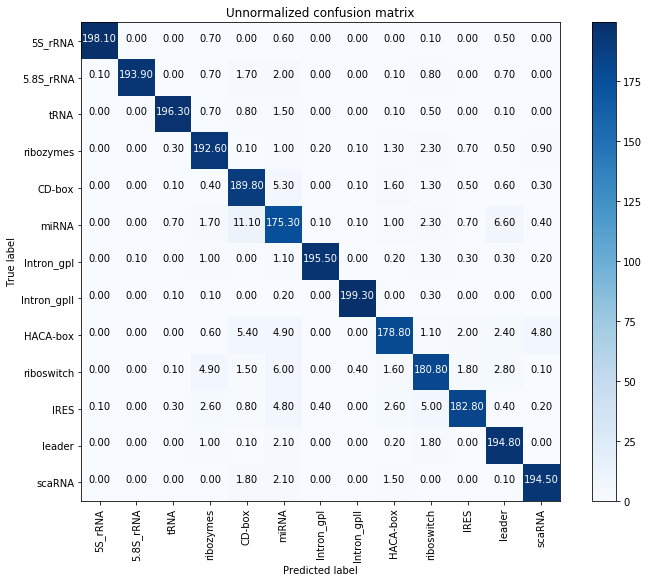

In [21]:
conf_mat_750s = np.array(conf_mat_750c1)
conf_mat_sum = conf_mat_750s[0,0,:,:]
for i in range(1,10):
    conf_mat_sum = conf_mat_sum + conf_mat_750s[i,0,:,:]
conf_mat_avg = np.true_divide(conf_mat_sum,10)
conf_mat_avg.dtype
plot_confusion_matrix(conf_mat_avg, classes=class_names, normalize=False,
                        title='Unnormalized confusion matrix')

Normalized confusion matrix


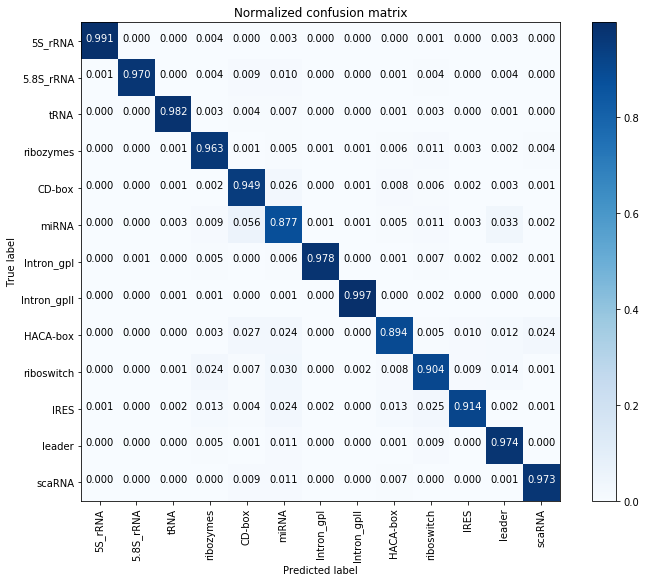

In [22]:
plot_confusion_matrix(conf_mat_avg, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')

In [23]:
for i in range(10):
    print(class_report_750c1['fold%i'%i])

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.99      0.95      0.97       200
           2       0.99      0.99      0.99       200
           3       0.92      0.97      0.95       200
           4       0.93      0.97      0.95       200
           5       0.84      0.88      0.86       200
           6       1.00      0.97      0.99       200
           7       1.00      1.00      1.00       200
           8       0.96      0.88      0.92       200
           9       0.94      0.84      0.89       200
          10       0.93      0.94      0.93       200
          11       0.91      0.96      0.93       200
          12       0.94      0.97      0.96       200

   micro avg       0.95      0.95      0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600

              precision    recall  f1-score   support

           0       1.00 

In [24]:
from __future__ import division
mcc_arr = []
acc_arr = []
rec_arr = []
prc_arr = []
f1s_arr = []
for k in range(10):
    i=k
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_dense5()
    model.load_weights("Checkpoints/Dense_RNAfold_revise2_%i_fold.h5" %i)
    y = model.predict([X_val[:,:,0:4],X_val[:,:,4:7]])
    y_test_non_category = [ np.argmax(t) for t in Y_val ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    mcc_small = []
    acc_small = []
    rec_small = []
    prc_small = []
    f1s_small = []
    for j in range(13):
        (tn, fp, fn, tp) = (0,0,0,0)
        classnum = j
        for i in range(len(y_test_non_category)):

             if (y_test_non_category[i]==classnum and y_predict_non_category[i] ==classnum):
                     tp+=1
             elif (y_test_non_category[i]==classnum and y_predict_non_category[i] !=classnum):
                     fn+=1
             elif (y_test_non_category[i]!=classnum and y_predict_non_category[i] ==classnum):
                     fp+=1
             elif (y_test_non_category[i]!=classnum and y_predict_non_category[i] !=classnum):
                    tn+=1
        val = (tp * tn) - (fp * fn)
        val = val / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc_small.append(val)
        vala = (tp + tn)/(tp + tn + fp + fn)
        acc_small.append(vala)
        valr = (tp)/(tp + fn)
        rec_small.append(valr)
        valp = (tp)/(tp + fp)
        prc_small.append(valp)
        valf = (2 * valr * valp)/(valr + valp)
        f1s_small.append(valf)
        #print(val)
    mcc_arr.append(mcc_small)
    acc_arr.append(acc_small)
    rec_arr.append(rec_small)
    prc_arr.append(prc_small)
    f1s_arr.append(f1s_small)
    print("***************")

***************
***************
***************
***************
***************
***************
***************
***************
***************
***************


In [25]:
import numpy 
mcc_arr = numpy.array(mcc_arr)
acc_arr = numpy.array(acc_arr)
rec_arr = numpy.array(rec_arr)
prc_arr = numpy.array(prc_arr)
f1s_arr = numpy.array(f1s_arr)

In [26]:
print(numpy.mean(acc_arr,axis=0))
print(numpy.mean(rec_arr,axis=0))
print(numpy.mean(prc_arr,axis=0))
print(numpy.mean(f1s_arr,axis=0))
print(numpy.mean(mcc_arr,axis=0))

[0.99919231 0.99761538 0.99796154 0.99161538 0.98711538 0.97834615
 0.998      0.99946154 0.98792308 0.98615385 0.99107692 0.99223077
 0.99523077]
[0.9905 0.9695 0.9815 0.963  0.949  0.8765 0.9775 0.9965 0.894  0.904
 0.914  0.974  0.9725]
[0.99900498 0.99947917 0.9921932  0.93131282 0.89244009 0.85143656
 0.99650432 0.99651734 0.94697048 0.916817   0.96891814 0.92974656
 0.96635226]
[0.99472672 0.9842496  0.98669304 0.94666626 0.91922347 0.86191841
 0.98687307 0.99649237 0.91916173 0.90950136 0.94013444 0.95100427
 0.96919014]
[0.99430449 0.98310024 0.98567943 0.94240767 0.91311553 0.85138452
 0.98586626 0.99621032 0.91341026 0.90253995 0.93608695 0.94730085
 0.96674444]


In [27]:
from sklearn import metrics
fpr = dict()
tpr = dict()
roc_auc = dict()
for k in range(1):
    i=9
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_dense5()
    model.load_weights("Checkpoints/Dense_RNAfold_revise2_%i_fold.h5" %i)
    y = model.predict([X_val[:,:,0:4],X_val[:,:,4:7]])
    for j in range(13):
        fpr[i,j], tpr[i,j], _ = roc_curve(Y_val[:, j], y[:, j])
        roc_auc[i,j] = metrics.auc(fpr[i,j], tpr[i,j])

In [28]:

for j in range(13):
    fpr[i,j], tpr[i,j], _ = roc_curve(Y_val[:, j], y[:, j])
    roc_auc[i,j] = metrics.auc(fpr[i,j], tpr[i,j])

In [29]:
fpr[9,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00458333,
       0.00458333, 1.        ])

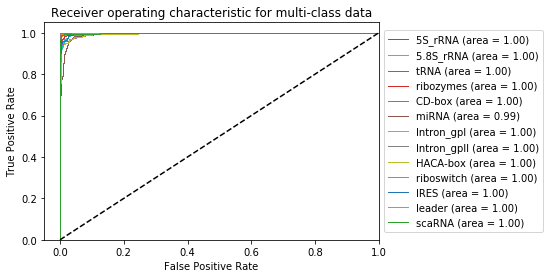

In [30]:
k=9
for i in range(13):
    plt.plot(fpr[k,i], tpr[k,i], lw=1,
             label='{0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[k,i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Results/1branch_ncrdense_roc.svg', bbox_inches='tight', format='svg', dpi=1500)
plt.show()

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [32]:
average_precision = dict()
average_precision["micro"] = average_precision_score(Y_val[:, i],
                                                        y[:, i],
                                                     average="micro")

In [ ]:
average_precision = dict()
for i in range(13):
    precision[i], recall[i], _ = precision_recall_curve(Y_val[:, i],
                                                        y[:, i])
    average_precision[i] = average_precision_score(Y_val[:, i], y[:, i])

In [40]:
y.shape

(2600, 13)

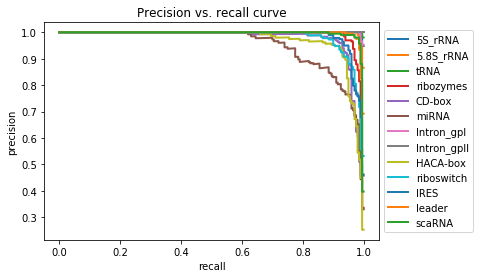

In [61]:
precision = dict()
recall = dict()
for i in range(13):
    precision[i], recall[i], _ = precision_recall_curve(Y_val[:, i], y[:, i])
    #plt.plot(recall[i], precision[i], lw=2, label='{0} (area = {1:0.2f})'
    #              ''.format(class_names[i], average_precision[i]))
    #plt.plot(recall[i], precision[i], lw=1,
    #         label='{0} (area = {1:0.2f})'
    #         ''.format(class_names[i], average_precision[i]))
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(class_names[i]))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Precision vs. recall curve")
plt.savefig('Results/1branch_ncrdense_prc.svg', bbox_inches='tight', format='svg', dpi=1500)
plt.show()

In [42]:
i=0
precision[i], recall[i], _ = precision_recall_curve(Y_val[:, i], y[:, i])

In [52]:
average_precision

{'micro': 0.9951852826947564}

In [56]:
average_precision = dict()
for i in range(13):
    precision[i], recall[i], _ = precision_recall_curve(Y_val[:, i],
                                                        y[:, i])
    average_precision[i] = average_precision_score(Y_val[:, i], y[:, i])

In [ ]:
average_precision

In [ ]:
conf_mat_list = conf_mat_avg.tolist()
conf_mat_list

In [ ]:
results = [
 [195.8, 0.0, 0.3, 0.6, 0.5, 1.1, 0.0, 0.0, 0.0, 0.8, 0.3, 0.5, 0.1],
 [0.6, 189.7, 0.8, 0.8, 2.1, 0.8, 0.0, 0.0, 1.2, 2.5, 0.1, 1.4, 0.0],
 [0.0, 0.0, 196.7, 0.6, 0.8, 1.7, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.3, 190.2, 0.3, 1.4, 1.2, 0.0, 0.9, 3.0, 1.2, 0.5, 1.0],
 [0.0, 0.0, 0.4, 0.4, 188.6, 4.9, 0.1, 0.3, 2.1, 1.4, 0.1, 1.0, 0.7],
 [0.0, 0.1, 5.7, 1.6, 16.0, 163.9, 0.3, 0.1, 1.7, 2.9, 0.2, 7.2, 0.3],
 [0.0, 0.0, 0.0, 1.5, 0.2, 0.5, 193.3, 0.0, 0.3, 3.4, 0.2, 0.3, 0.3],
 [0.0, 0.0, 0.5, 0.3, 0.1, 0.0, 0.0, 198.7, 0.3, 0.1, 0.0, 0.0, 0.0],
 [0.3, 0.2, 0.4, 0.2, 5.5, 6.3, 1.1, 0.0, 170.5, 4.9, 1.2, 2.2, 7.2],
 [0.4, 0.4, 1.8, 4.4, 1.6, 4.6, 0.2, 1.0, 1.2, 178.2, 0.9, 5.3, 0.0],
 [0.4, 0.4, 1.4, 5.4, 2.9, 3.7, 2.4, 0.3, 5.4, 10.5, 164.8, 1.0, 1.4],
 [0.0, 0.0, 0.4, 1.2, 1.1, 3.1, 0.0, 0.3, 0.2, 2.0, 0.0, 191.7, 0.0],
 [0.1, 0.0, 0.0, 0.2, 2.2, 3.7, 0.0, 0.0, 1.5, 0.8, 0.2, 0.0, 191.3]
]